100%|██████████| 187M/187M [00:07<00:00, 26.3MB/s]


Extracting data/GTSRB/gtsrb/GTSRB-Training_fixed.zip to data/GTSRB/gtsrb


100%|██████████| 89.0M/89.0M [00:04<00:00, 21.9MB/s]


Extracting data/GTSRB/gtsrb/GTSRB_Final_Test_Images.zip to data/GTSRB/gtsrb


100%|██████████| 99.6k/99.6k [00:00<00:00, 272kB/s]


Extracting data/GTSRB/gtsrb/GTSRB_Final_Test_GT.zip to data/GTSRB/gtsrb
Epoch [1/30]
Training Loss: 1.648
Training Accuracy: 50.37%
Training Precision: 0.486, Recall: 0.504, F1-Score: 0.482
Testing Accuracy: 85.41%
Testing Precision: 0.857, Recall: 0.854, F1-Score: 0.833
Best Testing Accuracy: 85.41%
--------------------
Epoch [2/30]
Training Loss: 0.716
Training Accuracy: 76.37%
Training Precision: 0.757, Recall: 0.764, F1-Score: 0.758
Testing Accuracy: 93.76%
Testing Precision: 0.941, Recall: 0.938, F1-Score: 0.934
Best Testing Accuracy: 93.76%
--------------------
Epoch [3/30]
Training Loss: 0.540
Training Accuracy: 81.96%
Training Precision: 0.816, Recall: 0.820, F1-Score: 0.817
Testing Accuracy: 94.70%
Testing Precision: 0.950, Recall: 0.947, F1-Score: 0.946
Best Testing Accuracy: 94.70%
--------------------
Epoch [4/30]
Training Loss: 0.451
Training Accuracy: 85.03%
Training Precision: 0.848, Recall: 0.850, F1-Score: 0.849
Testing Accuracy: 95.73%
Testing Precision: 0.959, Recall

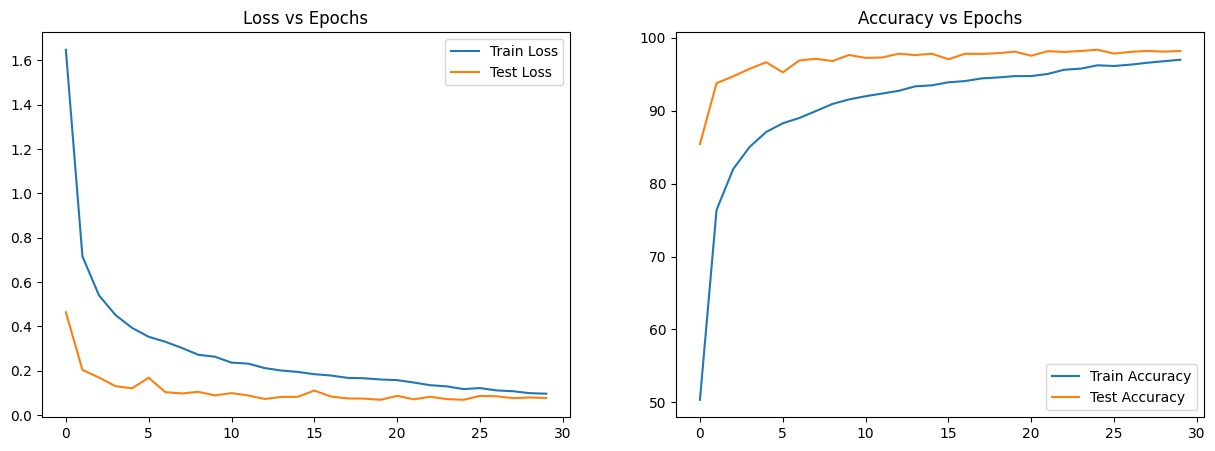

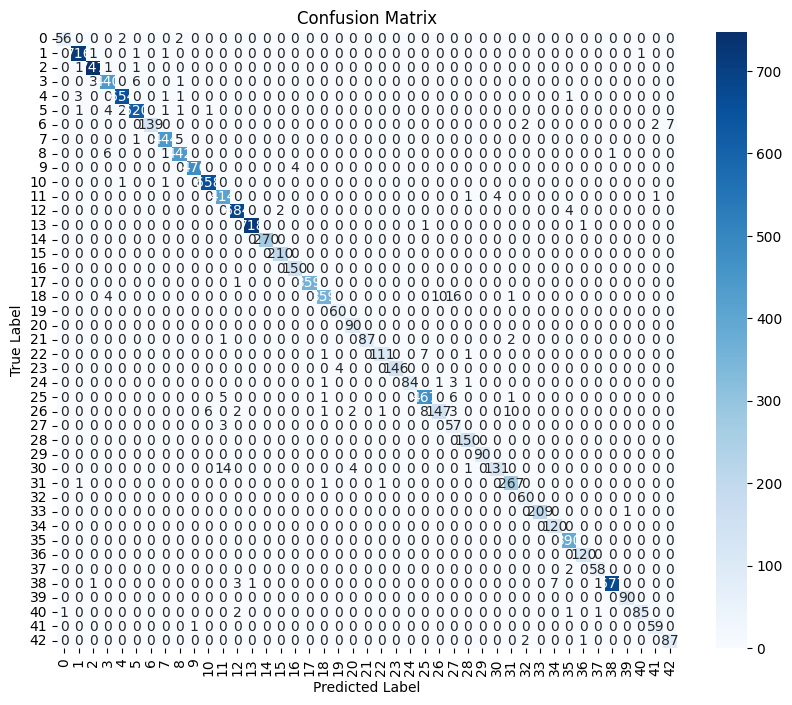

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import GTSRB
from torchvision import transforms
import numpy as np
import cv2
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define CLAHE preprocessing
def clahe_preprocess(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(image)  # Apply CLAHE
    return np.stack([enhanced_image] * 3, axis=-1)  # Convert back to 3-channel

# Define transformations for the training and testing datasets
train_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, hue=0.2, saturation=0.2),
    transforms.Lambda(lambda img: torch.tensor(clahe_preprocess(np.array(img)), dtype=torch.float32).permute(2, 0, 1)),
    transforms.Normalize((0.3337, 0.3064, 0.3171), (0.2672, 0.2564, 0.2629))
])

test_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Lambda(lambda img: torch.tensor(clahe_preprocess(np.array(img)), dtype=torch.float32).permute(2, 0, 1)),
    transforms.Normalize((0.3337, 0.3064, 0.3171), (0.2672, 0.2564, 0.2629))
])

# Root directory for the dataset
root_dir = './data/GTSRB'

# Load datasets with transformations
gtsrb_train = GTSRB(root=root_dir, split='train', transform=train_transforms, download=True)
gtsrb_test = GTSRB(root=root_dir, split='test', transform=test_transforms, download=True)

# Create DataLoaders
train_loader = DataLoader(gtsrb_train, batch_size=32, shuffle=True)
test_loader = DataLoader(gtsrb_test, batch_size=32, shuffle=False)

# CNN Model
class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes):
        super(TrafficSignCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Define device, model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 43  # GTSRB dataset has 43 traffic sign classes
model = TrafficSignCNN(num_classes=num_classes).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and Validation Loop
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []
best_test_acc = 0.0
epochs = 30

for epoch in range(epochs):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    all_train_preds, all_train_labels = [], []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        all_train_preds.extend(predicted.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_precision = precision_score(all_train_labels, all_train_preds, average='weighted', zero_division=0)
    train_recall = recall_score(all_train_labels, all_train_preds, average='weighted', zero_division=0)
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted', zero_division=0)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation Loop
    model.eval()
    test_running_loss, correct_test, total_test = 0.0, 0, 0
    all_test_preds, all_test_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            all_test_preds.extend(predicted.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

    test_loss = test_running_loss / len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    test_precision = precision_score(all_test_labels, all_test_preds, average='weighted', zero_division=0)
    test_recall = recall_score(all_test_labels, all_test_preds, average='weighted', zero_division=0)
    test_f1 = f1_score(all_test_labels, all_test_preds, average='weighted', zero_division=0)

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    if test_accuracy > best_test_acc:
        best_test_acc = test_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

    # Detailed Epoch Metrics
    print(f'Epoch [{epoch+1}/{epochs}]')
    print(f'Training Loss: {train_loss:.3f}')
    print(f'Training Accuracy: {train_accuracy:.2f}%')
    print(f'Training Precision: {train_precision:.3f}, Recall: {train_recall:.3f}, F1-Score: {train_f1:.3f}')
    print(f'Testing Accuracy: {test_accuracy:.2f}%')
    print(f'Testing Precision: {test_precision:.3f}, Recall: {test_recall:.3f}, F1-Score: {test_f1:.3f}')
    print(f'Best Testing Accuracy: {best_test_acc:.2f}%')
    print('--------------------')

# Plotting Metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label='Train Loss')
ax1.plot(test_losses, label='Test Loss')
ax1.legend()
ax1.set_title('Loss vs Epochs')
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(test_accuracies, label='Test Accuracy')
ax2.legend()
ax2.set_title('Accuracy vs Epochs')
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
